In [1]:
import os
GPU_id = 1
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import sys
sys.path.insert(1, '../')

In [3]:
import torch
import pandas as pd
import numpy as np
from time import time 

from fastai import *
from fastai.basic_data import *
from fastai.basic_data import *
from fastai.tabular import *
from fastai.basic_data import DataBunch
from fastai.tabular import TabularModel

import cudf

from ds_itr.preproc import Normalize, FillMissing, Categorify, Preprocessor
from ds_itr.dl_encoder import DLLabelEncoder
from ds_itr.ds_iterator import GPUDatasetIterator
from ds_itr.batchloader import FileItrDataset, DLCollator, DLDataLoader
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


In [4]:
torch.__version__, cudf.__version__

('1.4.0.dev20191111', '0.11.0a+2570.g7a87503c3.dirty')

In [5]:
%load_ext snakeviz
# load snakeviz if you want to run profiling

In [6]:
# to_cpu = True

<h3> Dataset Gathering: Define files in the training and validation datasets. </h3>

In [7]:
# data_path = '/rapids/notebooks/jperez/Documents/ds-itr/examples/'
data_path = '/rapidsdl/jperez/Documents/joc/output/'
#df_test = 'test/'
df_valid = 'validation_feature_vectors_integral.csv/'
df_train = 'train_feature_vectors_integral_eval.csv/'

train_set = [data_path + df_train + x for x in os.listdir(data_path + df_train) if x.startswith("part")] 
valid_set = [data_path + df_valid + x for x in os.listdir(data_path + df_valid) if x.startswith("part")] 

In [8]:
len(train_set), len(valid_set)

(200, 100)

<h4>Grab column information</h4>

In [9]:
cols = open('/rapidsdl/jperez/Documents/joc/output/' + 'train_feature_vectors_integral_eval.csv.header').read().splitlines()

In [10]:
cat_names = ['display_id', 'is_leak', 'doc_event_id', 'ad_id', 'doc_id', 'doc_ad_entity_id', 'doc_event_entity_id', 'doc_event_entity_id', 'doc_ad_source_id', 'doc_event_source_id', 'event_geo_location', 'ad_advertiser', 'event_country_state', 'doc_ad_publisher_id', 'doc_event_publisher_id', 'doc_ad_topic_id', 'doc_event_topic_id', 'event_country', 'doc_ad_category_id', 'doc_event_category_id', 'event_hour', 'event_platform', 'traffic_source', 'event_weekend', 'user_has_already_viewed_doc']
cont_names =  ['pop_ad_id_conf', 'pop_document_id_conf', 'user_doc_ad_sim_categories_conf', 'user_doc_ad_sim_topics_conf', 'pop_publisher_id_conf', 'pop_advertiser_id_conf', 'pop_campaign_id_conf', 'pop_source_id_conf', 'pop_entity_id_conf', 'pop_topic_id_conf', 'pop_category_id_conf', 'pop_ad_id', 'pop_document_id', 'pop_publisher_id', 'pop_advertiser_id', 'pop_campaign_id', 'pop_source_id', 'pop_entity_id', 'pop_topic_id', 'pop_category_id', 'user_doc_ad_sim_categories', 'user_doc_ad_sim_topics', 'user_doc_ad_sim_entities', 'doc_event_doc_ad_sim_categories', 'doc_event_doc_ad_sim_topics', 'doc_event_doc_ad_sim_entities', 'user_views', 'ad_views', 'doc_views', 'doc_event_days_since_published', 'doc_event_hour', 'doc_ad_days_since_published'] #+ [i for i in ds.columns if i not in cat_names and i not in ['label']]
cat_names = [name for name in cat_names if name in cols]
cont_names = [name for name in cont_names if name in cols]


<h3>Preprocessing:</h3> <p>Select operations to perform, create the Preprocessor object, create dataset iterator object and collect the stats on the training dataset</p>

In [11]:
%%time
a,b,c = Normalize(), FillMissing(), Categorify()
procs = [a,b,c]

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 12.9 µs


In [12]:
%%time
proc = Preprocessor(cat_names=cat_names, cont_names=cont_names, label_name=['label'], ops=procs, to_cpu=to_cpu)

CPU times: user 16 µs, sys: 3 µs, total: 19 µs
Wall time: 21.2 µs


In [13]:
%%time
trains_itrs = GPUDatasetIterator(train_set,names=cols, engine='csv')

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 10 µs


In [14]:
%%time
proc.update_stats(trains_itrs)

CPU times: user 12min 9s, sys: 2min 12s, total: 14min 22s
Wall time: 3min 51s


<h5>Gather embeddings using statistics gathered in the Read phase.</h5>

In [15]:
embeddings = [x[1] for x in c.get_emb_sz(proc.encoders, proc.cat_names)]

<h5>Create the file iterators using the FileItrDataset Class.</h5>

In [16]:
%%time
t_batch_sets = [FileItrDataset(x, names=cols, engine='csv', batch_size=400000) for x in train_set]
v_batch_sets = [FileItrDataset(x, names=cols, engine='csv', batch_size=400000) for x in valid_set]

CPU times: user 57.7 s, sys: 31.6 s, total: 1min 29s
Wall time: 1min 29s


In [17]:
%%time
t_chain = torch.utils.data.ChainDataset(t_batch_sets)
v_chain = torch.utils.data.ChainDataset(v_batch_sets)

CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 13.8 µs


<h5>Use the Deep Learning Collator to create a collate function to pass to the dataloader.</h5>

In [18]:
%%time
dlc = DLCollator(preproc=proc)

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 22.4 µs


In [19]:
%%time
t_data = DLDataLoader(t_chain, collate_fn=dlc.gdf_col, pin_memory=False, num_workers=0)
v_data = DLDataLoader(v_chain, collate_fn=dlc.gdf_col, pin_memory=False, num_workers=0)

CPU times: user 71 µs, sys: 15 µs, total: 86 µs
Wall time: 88.5 µs


<h4>After creating the Dataloaders you can leverage fastai framework to create Machine Learning models</h4>

In [20]:
databunch = DataBunch(t_data, v_data, collate_fn=dlc.gdf_col, device="cuda")

In [21]:
%%time
model = TabularModel(emb_szs = embeddings, n_cont=len(cont_names), out_sz=2, layers=[512,256])

learn =  Learner(databunch, model, metrics=[accuracy])
learn.loss_func = torch.nn.CrossEntropyLoss()


CPU times: user 7.13 s, sys: 558 ms, total: 7.69 s
Wall time: 2.89 s


In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-02
Min loss divided by 10: 1.74E-02


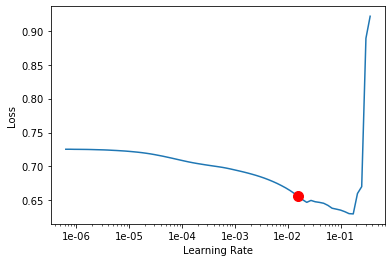

In [23]:
learn.recorder.plot(show_moms=True, suggestion=True)

In [24]:
learning_rate = 2e-2
epochs = 1

In [25]:
start = time()
learn.fit_one_cycle(epochs,learning_rate)
t_final = time() - start 

epoch,train_loss,valid_loss,accuracy,time
0,0.422798,0.430590,0.816544,10:48


In [26]:
del learn 
del model
del databunch
torch.cuda.empty_cache() 